In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import random
import numpy as np

In [40]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Limpieza de Datos con Pandas

### Limpieza de datos

In [41]:
import os
import pandas as pd

def create_dataframe(root_path):
    filepaths = []
    labels = []

    # Verificamos que la ruta exista
    if not os.path.exists(root_path):
        print(f"Error: La ruta {root_path} no existe. Verifica la dirección.")
        return None

    # Recorrer las carpetas (clases)
    for folder in os.listdir(root_path):
        folder_path = os.path.join(root_path, folder)
        
        # Solo entramos si es una carpeta (ej: 'fractured', 'not_fractured')
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                # Filtrar solo imágenes
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    fpath = os.path.join(folder_path, file)
                    filepaths.append(fpath)
                    labels.append(folder)
    
    # Crear y retornar el DataFrame
    df = pd.DataFrame({
        'filepath': filepaths,
        'label': labels
    })
    return df

# Rutas a los datasets
train_dir = 'data/Bone_Fracture_Binary_Classification/train' 
val_dir = 'data/Bone_Fracture_Binary_Classification/val' 
test_dir = 'data/Bone_Fracture_Binary_Classification/test'  

# Crear los DataFrames
train_df = create_dataframe(train_dir)
val_df = create_dataframe(val_dir)
test_df = create_dataframe(test_dir)

# Verificación rápida
print(f"Train data: {len(train_df)} imágenes")
print(f"Val data: {len(val_df)} imágenes")
print(f"Test data: {len(test_df)} imágenes")
print(train_df.head()) # Para ver que las columnas 'filepath' y 'label' existen

Train data: 9246 imágenes
Val data: 829 imágenes
Test data: 506 imágenes
                                            filepath      label
0  data/Bone_Fracture_Binary_Classification/train...  fractured
1  data/Bone_Fracture_Binary_Classification/train...  fractured
2  data/Bone_Fracture_Binary_Classification/train...  fractured
3  data/Bone_Fracture_Binary_Classification/train...  fractured
4  data/Bone_Fracture_Binary_Classification/train...  fractured


In [42]:
# Definimos la clase del Dataset
class BoneFractureDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame con columnas 'filepath' y 'label'.
            transform (callable, optional): Transformaciones (resize, normalize, etc).
        """
        self.dataframe = dataframe
        self.transform = transform
        
        # Mapeamos etiquetas de texto a números (ej: 'fractured': 1, 'normal': 0)
        # Ajusta esto según los nombres reales de tus carpetas
        self.label_map = {label: idx for idx, label in enumerate(dataframe['label'].unique())}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 1. Obtener la ruta de la imagen
        img_path = self.dataframe.iloc[idx]['filepath']
        
        # 2. Cargar imagen (convertir a gris para LeNet)
        image = Image.open(img_path).convert('L') 
        
        # 3. Obtener etiqueta numérica
        label_str = self.dataframe.iloc[idx]['label']
        label = self.label_map[label_str]
        
        # 4. Aplicar transformaciones
        if self.transform:
            image = self.transform(image)
            
        # Retornamos la imagen y su etiqueta (como tensor flotante para la loss function)
        return image, torch.tensor(label, dtype=torch.float32)


In [43]:
# Definir transformaciones
transform = transforms.Compose([
    transforms.Resize((32, 32)), # Tamaño clásico LeNet
    transforms.ToTensor(),       # Convierte a Tensor y escala a [0, 1]
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalización estándar (-1 a 1)
])

# Instanciar el Dataset usando el DataFrame 'val_df' que creamos antes
# (Asumiendo que hiciste lo mismo para un 'train_df')
train_dataset = BoneFractureDataset(train_df, transform=transform)
val_dataset = BoneFractureDataset(val_df, transform=transform)
test_dataset = BoneFractureDataset(test_df, transform=transform)

# Crear los DataLoaders (esto es lo que itera sobre los datos)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [44]:
from PIL import Image
from tqdm import tqdm # Barra de progreso

def clean_dataframe(df):
    indices_to_drop = []
    print(f"Verificando {len(df)} imágenes...")
    
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            # Intentamos abrir la imagen completamente
            img = Image.open(row['filepath'])
            img.load() # Forzamos la lectura de los datos
        except OSError:
            print(f"Imagen corrupta encontrada y eliminada: {row['filepath']}")
            indices_to_drop.append(idx)
        except Exception as e:
            print(f"Error en imagen {row['filepath']}: {e}")
            indices_to_drop.append(idx)
            
    # Eliminamos las filas malas
    return df.drop(indices_to_drop)

# Limpiamos el dataframe de entrenamiento
train_df = clean_dataframe(train_df)
test_df = clean_dataframe(test_df)
val_df = clean_dataframe(val_df)

# IMPORTANTE: Recrear el Dataset y el DataLoader con el dataframe limpio
train_dataset = BoneFractureDataset(train_df, transform=transform)
val_dataset = BoneFractureDataset(val_df, transform=transform)
test_dataset = BoneFractureDataset(test_df, transform=transform)

# Crear los DataLoaders (esto es lo que itera sobre los datos)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Limpieza completada. Puedes entrenar ahora.")

Verificando 9246 imágenes...


 53%|█████▎    | 4884/9246 [00:06<00:04, 883.33it/s]

Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004143.jpg


 61%|██████    | 5597/9246 [00:07<00:03, 1168.94it/s]

Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004347.jpg


 66%|██████▌   | 6072/9246 [00:08<00:03, 832.63it/s] 

Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004134.jpg


 67%|██████▋   | 6168/9246 [00:08<00:04, 759.87it/s]

Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004308.jpg


 93%|█████████▎| 8553/9246 [00:10<00:00, 1116.85it/s]

Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004148.jpg
Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004149.jpg


100%|██████████| 9246/9246 [00:11<00:00, 800.13it/s] 


Verificando 506 imágenes...


 54%|█████▎    | 271/506 [00:00<00:00, 358.64it/s]

Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004143.jpg
Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004347.jpg


 61%|██████▏   | 311/506 [00:00<00:00, 320.55it/s]

Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004134.jpg
Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004308.jpg


 98%|█████████▊| 497/506 [00:01<00:00, 220.98it/s]

Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004148.jpg
Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004149.jpg


100%|██████████| 506/506 [00:01<00:00, 262.26it/s]


Verificando 829 imágenes...


 46%|████▋     | 384/829 [00:01<00:01, 253.05it/s]

Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004143.jpg
Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004347.jpg


 62%|██████▏   | 513/829 [00:01<00:01, 259.27it/s]

Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004134.jpg
Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004308.jpg


 97%|█████████▋| 803/829 [00:02<00:00, 364.98it/s]

Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004148.jpg
Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004149.jpg


100%|██████████| 829/829 [00:02<00:00, 284.85it/s]

Limpieza completada. Puedes entrenar ahora.


## LeNet5: Una Arquitectura Clásica de Red Neuronal Convolucional

In [45]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [46]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # C1: 1 canal de entrada (Escala de grises) -> 6 canales de salida
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)
        # S2: Pooling
        self.avgpool1 = nn.AvgPool2d(2, 2)
        # C3: 6 -> 16
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # S4: Pooling
        self.avgpool2 = nn.AvgPool2d(2, 2)
        
        # C5: Flatten. 
        # Si la imagen entra de 32x32, después de las convulsiones queda de 5x5.
        # 16 canales * 5 * 5 = 400 entradas
        self.fc1 = nn.Linear(16 * 5 * 5, 120)

        # FC6
        self.fc2 = nn.Linear(120, 84)

        # Ahora: 
        self.fc3 = nn.Linear(84, 1)  # <-- Solo 1 neurona para Binary Classification

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = self.avgpool1(x)
        x = torch.tanh(self.conv2(x))
        x = self.avgpool2(x)
        
        # Aplanamos (Flatten)
        x = x.view(x.size(0), -1) 

        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))

        x = self.fc3(x)  # Retorna el logit (sin sigmoide)

        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device)

# Como recreamos el modelo, debemos recrear el optimizador (para que coja los nuevos parámetros)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Modelo LeNet5 actualizado para clasificación binaria (1 salida).")

Modelo LeNet5 actualizado para clasificación binaria (1 salida).


In [47]:
# Hiperparámetros
num_epochs = 25
learning_rate = 0.001

# Definir la función de pérdida y el optimizador
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# ENTRENAMIENTO
train_losses = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # VALIDACIÓN
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (torch.sigmoid(outputs) > 0.5).float()
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total

    # Guardar métricas
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}] | '
          f'Train Loss: {avg_train_loss:.4f} | '
          f'Val Loss: {avg_val_loss:.4f} | '
          f'Val Acc: {val_acc:.2f}%')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'mejor_modelo_lenet.pth')
        print(f"   --> ¡Nuevo récord! Modelo guardado (Acc: {best_val_acc:.2f}%)")

print(f"\nEntrenamiento finalizado. Mejor exactitud lograda: {best_val_acc:.2f}%")

print("\n================ RESULTADOS FINALES ================")


def calcular_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


train_acc = calcular_accuracy(model, train_loader)
val_acc   = calcular_accuracy(model, val_loader)
test_acc  = calcular_accuracy(model, test_loader)

print(f"Train Acc: {train_acc:.2f}%")
print(f"Val Acc:   {val_acc:.2f}%")
print(f"Test Acc:  {test_acc:.2f}%")


/opt/anaconda3/lib/python3.13/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/25] | Train Loss: 0.5765 | Val Loss: 0.5353 | Val Acc: 74.73%
   --> ¡Nuevo récord! Modelo guardado (Acc: 74.73%)
Epoch [2/25] | Train Loss: 0.4711 | Val Loss: 0.4643 | Val Acc: 79.59%
   --> ¡Nuevo récord! Modelo guardado (Acc: 79.59%)
Epoch [3/25] | Train Loss: 0.3939 | Val Loss: 0.4425 | Val Acc: 80.07%
   --> ¡Nuevo récord! Modelo guardado (Acc: 80.07%)
Epoch [4/25] | Train Loss: 0.2727 | Val Loss: 0.3382 | Val Acc: 87.12%
   --> ¡Nuevo récord! Modelo guardado (Acc: 87.12%)
Epoch [5/25] | Train Loss: 0.1481 | Val Loss: 0.2754 | Val Acc: 89.91%
   --> ¡Nuevo récord! Modelo guardado (Acc: 89.91%)
Epoch [6/25] | Train Loss: 0.0836 | Val Loss: 0.1846 | Val Acc: 90.77%
   --> ¡Nuevo récord! Modelo guardado (Acc: 90.77%)
Epoch [7/25] | Train Loss: 0.0496 | Val Loss: 0.1522 | Val Acc: 93.92%
   --> ¡Nuevo récord! Modelo guardado (Acc: 93.92%)
Epoch [8/25] | Train Loss: 0.0303 | Val Loss: 0.1543 | Val Acc: 92.83%
Epoch [9/25] | Train Loss: 0.0204 | Val Loss: 0.1606 | Val Acc: 94.6

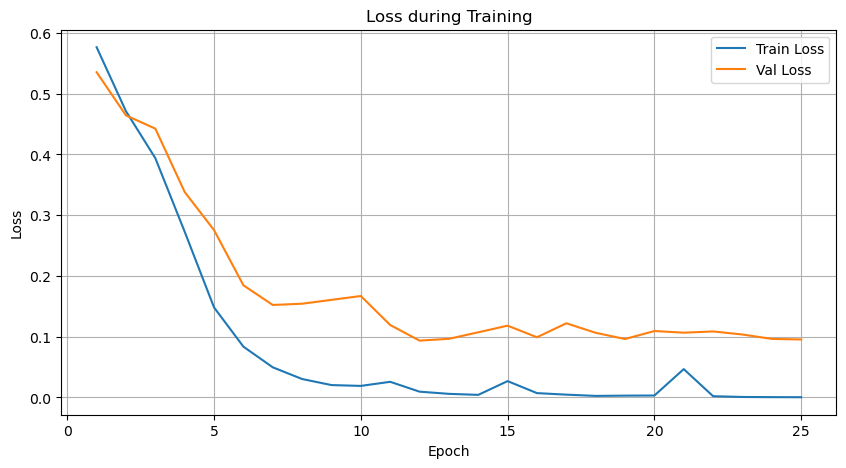

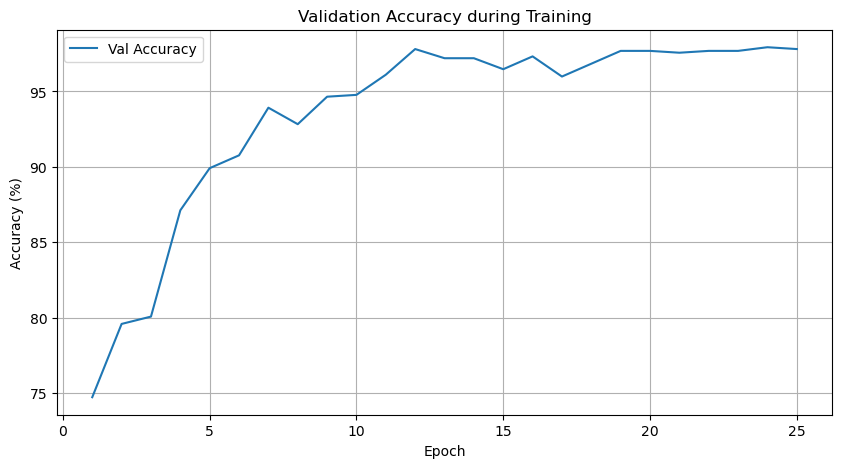

In [48]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.title("Loss during Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(epochs_range, val_accuracies, label="Val Accuracy")
plt.title("Validation Accuracy during Training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.show()

Overfitting! The bane of every machine learning practitioner's existence. When your model performs exceptionally well on training data but falters on unseen data, it's a clear sign that overfitting has taken hold. To combat this, we can employ several strategies:
1. **Cross-Validation**: This technique involves partitioning the dataset into multiple subsets, training the model on some subsets while validating it on others. This helps ensure that the model generalizes well to unseen data.
2. **Regularization**: Techniques like L1 and L2 regularization add a penalty to the loss function based on the magnitude of the model's coefficients. This discourages the model from becoming too complex and helps prevent overfitting.
3. **Dropout**: This method randomly "drops out" a fraction of the neurons during training, forcing the model to learn more robust features that are not reliant on specific neurons.
4. **Early Stopping**: By monitoring the model's performance on a validation set during training, we can halt the training process once the performance starts to degrade, preventing the model from overfitting to the training data.
5. **Data Augmentation**: Increasing the diversity of the training data through techniques like rotation, scaling, and flipping can help the model generalize better to new data.

In [49]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self, num_classes=2):
        super(LeNet5, self).__init__()
        
        # 1. Bloque de extracción de características (Convoluciones)
        # Input: 1 canal (Grayscale), 32x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2) # O MaxPool2d según tu preferencia
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        
        # 2. Capas completamente conectadas (Clasificación)
        # 16 canales * 5x5 tamaño de imagen resultante = 400 entradas
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        
        # 3. DEFINICIÓN DEL DROPOUT
        # p=0.5 significa que hay un 50% de probabilidad de apagar una neurona
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # --- Convoluciones ---
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # --- Aplanar (Flatten) ---
        x = x.view(-1, 16 * 5 * 5)
        
        # --- Capas Densas con DROPOUT ---
        
        # Capa 1
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  
        
        # Capa 2
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  
        
        x = self.fc3(x)
        
        return x

# Para instanciar el modelo:
model = LeNet5(num_classes= 1)
# Mover a GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [50]:
# Hiperparámetros
num_epochs = 25
learning_rate = 0.001

# Definir la función de pérdida y el optimizador
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# ENTRENAMIENTO
train_losses = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # VALIDACIÓN
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (torch.sigmoid(outputs) > 0.5).float()
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total

    # Guardar métricas
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}] | '
          f'Train Loss: {avg_train_loss:.4f} | '
          f'Val Loss: {avg_val_loss:.4f} | '
          f'Val Acc: {val_acc:.2f}%')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'mejor_modelo_lenet.pth')
        print(f"   --> ¡Nuevo récord! Modelo guardado (Acc: {best_val_acc:.2f}%)")

print(f"\nEntrenamiento finalizado. Mejor exactitud lograda: {best_val_acc:.2f}%")

print("\n================ RESULTADOS FINALES ================")


def calcular_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


train_acc = calcular_accuracy(model, train_loader)
val_acc   = calcular_accuracy(model, val_loader)
test_acc  = calcular_accuracy(model, test_loader)

print(f"Train Acc: {train_acc:.2f}%")
print(f"Val Acc:   {val_acc:.2f}%")
print(f"Test Acc:  {test_acc:.2f}%")


Epoch [1/25] | Train Loss: 0.6227 | Val Loss: 0.5998 | Val Acc: 67.44%
   --> ¡Nuevo récord! Modelo guardado (Acc: 67.44%)
Epoch [2/25] | Train Loss: 0.3984 | Val Loss: 0.3674 | Val Acc: 84.45%
   --> ¡Nuevo récord! Modelo guardado (Acc: 84.45%)
Epoch [3/25] | Train Loss: 0.2279 | Val Loss: 0.2832 | Val Acc: 89.06%
   --> ¡Nuevo récord! Modelo guardado (Acc: 89.06%)
Epoch [4/25] | Train Loss: 0.1430 | Val Loss: 0.2267 | Val Acc: 91.13%
   --> ¡Nuevo récord! Modelo guardado (Acc: 91.13%)
Epoch [5/25] | Train Loss: 0.1048 | Val Loss: 0.2108 | Val Acc: 91.62%
   --> ¡Nuevo récord! Modelo guardado (Acc: 91.62%)
Epoch [6/25] | Train Loss: 0.0771 | Val Loss: 0.1823 | Val Acc: 93.32%
   --> ¡Nuevo récord! Modelo guardado (Acc: 93.32%)
Epoch [7/25] | Train Loss: 0.0643 | Val Loss: 0.2259 | Val Acc: 91.98%
Epoch [8/25] | Train Loss: 0.0491 | Val Loss: 0.2116 | Val Acc: 92.47%
Epoch [9/25] | Train Loss: 0.0448 | Val Loss: 0.1672 | Val Acc: 93.92%
   --> ¡Nuevo récord! Modelo guardado (Acc: 93.92

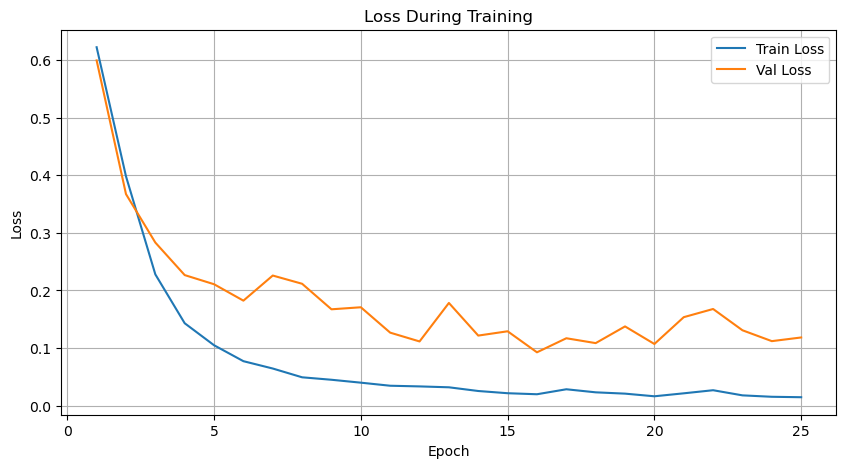

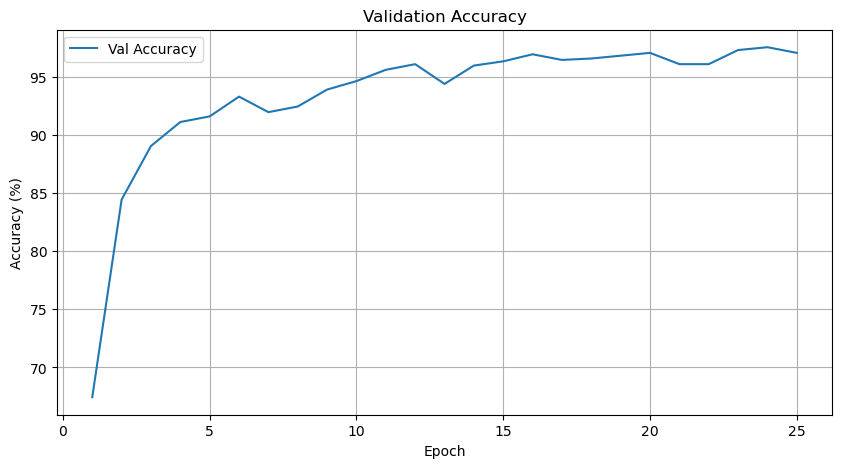

In [51]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.title("Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(epochs_range, val_accuracies, label="Val Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.show()

In [52]:
from thop import profile
import torch

# Suponiendo que tu modelo se llama "LeNet5"
model = LeNet5(num_classes=1)
model.eval()

# Input dummy de ejemplo (1 canal, 32x32)
input_tensor = torch.randn(1, 1, 32, 32)

# Calcula FLOPs y parámetros
flops, params = profile(model, inputs=(input_tensor,))

print(f"FLOPs: {flops:,}")
print(f"Params: {params:,}")


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
FLOPs: 417,340.0
Params: 60,941.0


In [54]:
import time
import torch

def medir_inference_time(model, device, input_size=(1, 1, 32, 32), runs=100):
    model.eval()
    model.to(device)

    dummy_input = torch.randn(input_size).to(device)

    # Warm-up (GPU necesita algunas ejecuciones para estabilizar)
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)

    # Medición
    tiempos = []
    with torch.no_grad():
        for _ in range(runs):
            start = time.time()
            _ = model(dummy_input)
            end = time.time()
            tiempos.append(end - start)

    avg_time = sum(tiempos) / runs
    std_time = torch.tensor(tiempos).std().item()

    print(f"\n==== INFERENCE TIME ====")
    print(f"Runs: {runs}")
    print(f"Promedio: {avg_time*1000:.4f} ms por imagen")
    print(f"Desviación estándar: {std_time*1000:.4f} ms")
    return avg_time, std_time

# Medir tiempo en CPU
medir_inference_time(model, device=torch.device('cpu'))
# Medir tiempo en GPU (si está disponible)
if torch.cuda.is_available():
    medir_inference_time(model, device=torch.device('cuda'))



==== INFERENCE TIME ====
Runs: 100
Promedio: 0.1991 ms por imagen
Desviación estándar: 0.1234 ms
